# INFO-4604/5604 HW2: Linear Classification 
## Deadline: Friday, October 2, 11:59pm MT

### Solution by: Kevin Nguyen


## Assignment overview

In this assignment, you will build a classifier that tries to infer whether tweets from [@realDonaldTrump](https://twitter.com/realDonaldTrump) were written by Trump himself or by a staff person.
This is an example of binary classification on a text dataset. 

It is known that Donald Trump uses an Android phone, and it has been observed that some of his tweets come from Android while others come from other devices (most commonly iPhone). It is widely believed that Android tweets are written by Trump himself, while iPhone tweets are written by other staff. For more information, you can read this [blog post by David Robinson](http://varianceexplained.org/r/trump-tweets/), written prior to the election, which finds a number of differences in the style and timing of tweets published under these two devices. (Some tweets are written from other devices, but for simplicity the dataset for this assignment is restricted to these two.)

This is a classification task known as "authorship attribution", which is the task of inferring the author of a document when the authorship is unknown. We will see how accurately this can be done with linear classifiers using word features.

You will need `sklearn` version 0.23 for this assignment.

### What to hand in

You will submit the assignment on Canvas. Submit a single Jupyter notebook named `hw2lastname.ipynb`, where lastname is replaced with your last name.

If you have any output that is not part of your notebook, you may submit that as a separate document, in a single PDF named `hw2lastname.pdf`. For example, this assignment requires you to create plots. You could do it directly with python using [matplotlib](https://matplotlib.org/), but if you wanted to create them using other software, that's acceptable as long as you put all of the figures in a single document and you clearly label them with the corresponding deliverable number.

When writing code in this notebook, you are encouraged to create additional cells in whatever way makes the presentation more organized and easy to follow. You are allowed to import additional Python libraries, but mostly you need sklearn and matplotlib.

### Submission policies

- **Collaboration:** You are allowed to work with one partner. You are still expected to write up your own solution. Each individual must turn in their own submission, and list your collaborator after your name.
- **Late submissions:** We allow each student to use up to 5 late days over the semester. You have late days, not late hours. This means that if your submission is late by any amount of time past the deadline, then this will use up a late day. If it is late by any amount beyond 24 hours past the deadline, then this will use a second late, and so on. Once you have used up all late days, late assignments will only be given credit in special circumstances.

## Getting started

In this assignment, you will experiment with perceptron and logistic regression in `sklearn`. Much of the code has already been written for you. We will use a class called `SGDClassifier` (which you should read about in the [sklearn documentation](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)), which  implements stochastic gradient descent (SGD) for a variety of loss functions, including both perceptron and logistic regression, so this will be a way to easily move between the two classifiers.

The code below will load the datasets. There are two data collections: the "training" data, which contains the tweets that you will use for training the classifiers, and the "testing" data, which are tweets that you will use to measure the classifier accuracy. The test tweets are instances the classifier has never seen before, so they are a good way to see how the classifier will behave on data it hasn't seen before. However, we still know the labels of the test tweets, so we can measure the accuracy.

For this problem, we will use what are called "bag of words" features, which are commonly used when doing classification with text. Each feature is a word, and the value of a feature for a particular tweet is number of times the word appears in the tweet (with value $0$ if the word does not appear in the tweet).

Run the block of code below to load the data. You don't need to do anything yet. Move on to "Problem 1" next.

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

df_train = pd.read_csv('http://cmci.colorado.edu/classes/INFO-4604/data/tweets.train.tsv', sep='\t', header=None)

Y_train = df_train.iloc[0:, 0].values
text_train = df_train.iloc[0:, 1].values

vec = CountVectorizer()
X_train = vec.fit_transform(text_train)
feature_names = np.asarray(vec.get_feature_names())

df_test = pd.read_csv('http://cmci.colorado.edu/classes/INFO-4604/data/tweets.test.tsv', sep='\t', header=None)
Y_test = df_test.iloc[0:, 0].values
text_test = df_test.iloc[0:, 1].values

X_test = vec.transform(text_test)


In [71]:
print("Number of training instances: " + str(len(df_train)))
print("Number of test instances: " + str(len(df_test)))
print("Number of features: " + str(len(feature_names)))

android = (Y_train == "Android")
iphone = (Y_train == "iPhone")

android_pct = sum(android) / len(df_train)
iphone_pct = sum(iphone) / len(df_train)

print(android_pct, iphone_pct)

Number of training instances: 2593
Number of test instances: 185
Number of features: 4829
0.5163902815271886 0.4836097184728114


## Problem 1: Understand the data [6 points]

Before doing anything else, take time to understand the code above.

The variables `df_train` and `df_test` are dataframes that store the training (and testing) datasets, which are contained in tab-separated files where the first column is the label and the second column is the text of the tweet.

The [`CountVectorizer`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) class converts the raw text into a bag-of-words into a feature vector representation that `sklearn` can use.

You should print out the values of the variables and write any other code needed to answer the following questions.

#### Deliverable 1.1: How many training instances are in the dataset? How many test instances?

There are 2593 instances in the trainning dataset and 185 instances in the testing dataset.

#### Deliverable 1.2: How many features are in the training data?

There are 4829 features in the training dataset.

#### Deliverable 1.3: What is the distribution of labels in the training data? That is, what percentage of instances are 'Android' versus 'iPhone'?


Approximately 51.64% of the labels in the training data are 'Android' and 48.36% of the labels are 'iPhone'.


## Problem 2: Perceptron [6 points]

The code below trains an [`SGDClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) using the perceptron loss, then it measures the accuracy of the classifier on the test data, using `sklearn`'s [`accuracy_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) function. 

The `fit` function trains the classifier. The feature weights are stored in the `coef_` variable after training. The `predict` function of the trained `SGDClassifier` outputs the predicted label for a given instance or list of instances.

Additionally, this code displays the features and their weights in sorted order, which you may want to examine to understand what the classifier is learning. In this dataset, the $\textrm{Android}$ class is considered the "negative" class because it comes first in the data.

There are 3 keyword arguments that have been added to the code below. It is important you keep the same values of these arguments whenever you create an `SGDClassifier` instance in this assignment so that you get consistent results. They are:

- `max_iter` is one of the stopping criteria, which is the maximum number of iterations/epochs the algorithm will run for.

- `tol` is the other stopping criterion, which is how small the difference between the current loss and previous loss should be before stopping.

- `random_state` is a seed for pseudorandom number generation. The algorithm uses randomness in the way the training data are sorted, which will affect the solution that is learned, and even the accuracy of that solution.

Wait a minute $-$ in class we learned that the loss function is convex, so the algorithm will find the same minimum regardless of how it is trained. Why is there random variation in the output? The reason is that even though there is only one minimum value of the loss, there may be different weights that result in the same loss, so randomness is a matter of tie-breaking. What's more, while different weights may have the same loss, they could lead to different classification accuracies, because the loss function is not the same as accuracy. (Unless accuracy was your loss function... which is possible, but uncommon because it turns out to be a difficult function to optimize.)

Note that different computers may still give different answers, despite keeping these settings the same, because of how pseudorandom numbers are generated with different operating systems and Python environments. 

To begin, run the code in the cell below without modification.

#### Deliverable 2.1: Based on the training accuracy, do you conclude that the data are linearly separable? Why or why not?

If the data were linearly separable, the training accuracy would eventually reach 100% after SGD. Since the training accuracy is not 100%, the training data is not linearly separable. 

#### Deliverable 2.2: Which feature most increases the likelihood that the class is 'Android' and which feature most increases the likelihood that the class is 'iPhone'? 

"00" most increases the likleihood that the class is 'Android'. 
"imwithyou" most increases the likelihood that the class is 'iPhone'

<br />

One technique for improving the resulting model with perceptron (or stochastic gradient descent learning in general) is to take an average of the weight vectors learned at different iterations of the algorithm, rather than only using the final weights that minimize the loss. That is, calculate $\bar{\mathbf{w}} = \sum_{t=1}^T \mathbf{w}^{(t)}$ where $\mathbf{w}^{(t)}$ is the weight vector at iteration $t$ of the algorithm and $T$ is the number of iterations, and then use $\bar{\mathbf{w}}$ when making classifications on new data.

To use this technique in your classifier, add the keyword argument `average=True` to the `SGDClassifier` function. Try it now.

#### Deliverable 2.3: Compare the initial training/test accuracies to the training/test accuracies after doing averaging. What happens? Why do you think averaging the weights from different iterations has this effect?

The training accuracy goes down but the testing accuracy increases. We can decrease the noise effect from single observations by looking a the average of the each update. The average is a good approximation of the true gradient. 


In [3]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, precision_score

classifier = SGDClassifier(loss='perceptron', max_iter=1000, tol=1.0e-12, random_state=123, eta0=100)
classifier.fit(X_train, Y_train)


print("Number of SGD iterations: %d" % classifier.n_iter_)
print("Training accuracy: %0.6f" % accuracy_score(Y_train, classifier.predict(X_train)))
print("Testing accuracy: %0.6f" % accuracy_score(Y_test, classifier.predict(X_test)))

print("\nFeature weights:")
args = np.argsort(classifier.coef_[0])
for a in args:
    print(" %s: %0.4f" % (feature_names[a], classifier.coef_[0][a]))

Number of SGD iterations: 38
Training accuracy: 0.997300
Testing accuracy: 0.864865

Feature weights:
 00: -1.5070
 veterans: -1.2056
 wow: -1.2056
 talking: -1.1052
 called: -1.1052
 badly: -1.0047
 into: -1.0047
 stay: -0.9042
 actually: -0.9042
 hillaryclinton: -0.9042
 woman: -0.9042
 talks: -0.9042
 look: -0.9042
 weak: -0.8038
 mails: -0.8038
 illegals: -0.8038
 standing: -0.8038
 allowed: -0.8038
 care: -0.8038
 making: -0.8038
 spent: -0.8038
 donaldtrump: -0.8038
 sources: -0.8038
 wrong: -0.8038
 cruz: -0.7033
 reported: -0.7033
 scared: -0.7033
 frontrunner: -0.7033
 expensive: -0.7033
 four: -0.7033
 game: -0.7033
 old: -0.7033
 oregon: -0.7033
 use: -0.7033
 mr: -0.7033
 order: -0.7033
 texas: -0.7033
 charge: -0.7033
 reviews: -0.7033
 statement: -0.7033
 _username_: -0.7033
 taking: -0.6028
 fake: -0.6028
 presumptive: -0.6028
 turned: -0.6028
 sigh: -0.6028
 read: -0.6028
 teleprompter: -0.6028
 tim: -0.6028
 doesn: -0.6028
 isn: -0.6028
 many: -0.6028
 senator: -0.6028

 navarro: 0.0000
 narrative: 0.0000
 naples: 0.0000
 boycotted: 0.0000
 boynton: 0.0000
 naive: 0.0000
 negotiating: 0.0000
 myanmar: 0.0000
 nightmare: 0.0000
 booed: 0.0000
 operatives: 0.0000
 operations: 0.0000
 opens: 0.0000
 openingceremony: 0.0000
 blew: 0.0000
 omaha: 0.0000
 oldest: 0.0000
 blind: 0.0000
 oklahoma: 0.0000
 ohiovotesearly: 0.0000
 depressing: 0.0000
 offering: 0.0000
 offered: 0.0000
 nm: 0.0000
 offended: 0.0000
 obviously: 0.0000
 obvious: 0.0000
 observer: 0.0000
 objectified: 0.0000
 obamacarefail: 0.0000
 blown: 0.0000
 nuts: 0.0000
 bluffs: 0.0000
 november8th: 0.0000
 bodyguards: 0.0000
 northwestern: 0.0000
 normal: 0.0000
 nonsense: 0.0000
 october: 0.0000
 mvp: 0.0000
 brady: 0.0000
 muir: 0.0000
 miss: 0.0000
 bright: 0.0000
 british: 0.0000
 mishandled: 0.0000
 mired: 0.0000
 broadcast: 0.0000
 minute: 0.0000
 broaddrick: 0.0000
 mining: 0.0000
 minds: 0.0000
 brother: 0.0000
 bruising: 0.0000
 miles: 0.0000
 brigade: 0.0000
 brutal: 0.0000
 microph

 numerous: 0.0000
 interest: 0.0000
 how: 0.0000
 higher: 0.0000
 county: 0.0000
 working: 0.0000
 supreme: 0.0000
 follow: 0.0000
 maga: 0.0000
 liked: 0.0000
 much: 0.0000
 rallies: 0.0000
 out: 0.0000
 now: 0.0000
 never: 0.0000
 prosecuted: 0.0000
 dollars: 0.0000
 let: 0.0000
 anti: 0.0000
 poll: 0.0000
 leaders: 0.0000
 disgraceful: 0.0000
 before: 0.0000
 term: 0.0000
 candidate: 0.0000
 including: 0.0000
 talk: 0.0000
 regarding: 0.0000
 vets: 0.0000
 spoiler: 0.0000
 race: 0.0000
 win: 0.0000
 no: 0.0000
 cover: 0.0000
 funding: 0.0000
 them: 0.0000
 drop: 0.0000
 mike: 0.0000
 even: 0.0000
 refuses: 0.0000
 change: 0.0000
 workers: 0.0000
 did: 0.0000
 guy: 0.0000
 she: 0.0000
 meeting: 0.1005
 on: 0.1005
 massive: 0.1005
 true: 0.1005
 united: 0.1005
 we: 0.1005
 melania: 0.1005
 have: 0.1005
 almost: 0.1005
 last: 0.1005
 told: 0.1005
 ohio: 0.1005
 going: 0.1005
 hispanic: 0.1005
 wisconsin: 0.1005
 ivanka: 0.1005
 took: 0.1005
 immigration: 0.1005
 keep: 0.1005
 these: 0.

In [4]:
classifier2 = SGDClassifier(loss='perceptron', max_iter=1000, tol=1.0e-12, random_state=123, eta0=100, average = True)
classifier2.fit(X_train, Y_train)

print("Number of SGD iterations: %d" % classifier2.n_iter_)
print("Training accuracy: %0.6f" % accuracy_score(Y_train, classifier2.predict(X_train)))
print("Testing accuracy: %0.6f" % accuracy_score(Y_test, classifier2.predict(X_test)))

Number of SGD iterations: 38
Training accuracy: 0.991901
Testing accuracy: 0.870270


## Problem 3: Logistic regression [15 points]

For this problem, create a new `SGDClassifier`, this time setting the `loss` argument to `'log'`, which will train a logistic regression classifier. Set `average=False` for the remaining problems.

Once you have trained the classifier, you can use the `predict` function to get the classifications, as with perceptron. Additionally, logistic regression provides probabilities for the predictions. You can get the probabilities by calling the `predict_proba` function. This will give a list of two numbers; the first is the probability that the class is $\textrm{Android}$ and the second is the probability that the class is $\textrm{iPhone}$.


For the first task, add the keyword argument `alpha` to the `SGDClassifier` function. This is the regularization strength, called $\lambda$ in lecture. If you don't specify `alpha`, it defaults to $0.0001$. Experiment with other values and see how this affects the outcome.

#### Deliverable 3.1: Calculate the training and testing accuracy when `alpha` is one of $[0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]$. Create a plot where the x-axis is `alpha` and the y-axis is accuracy, with two lines (one for training and one for testing). You can borrow the code from HW1 for generating plots in Python. Use [a log scale for the x-axis](https://matplotlib.org/examples/pylab_examples/log_demo.html) so that the `alpha` values are spaced evenly.

See below.

#### Deliverable 3.2: Examine the classifier probabilities using the `predict_proba` function when training with different values of `alpha`. What do you observe? How does `alpha` affect the prediction probabilities, and why do you think this happens?

The predicted probabilities generally moved closer to 50% (i.e. the weights moved closer to zero) as alpha increased. This is because we increased our regularization multipier which increases the penalty placed on large weights. We use regularization to prevent overfitting of our model. 

<br />

Now remove the `alpha` argument so that it goes back to the default value. We'll now look at the effect of the learning rate. By default, `sklearn` uses an "optimal" learning rate based on some heuristics that work well for many problems. However, it can be good to see how the learning rate can affect the algorithm.

For this task, add the keyword argument `learning_rate` to the `SGDClassifier` function and set the value to `invscaling`. This defines the learning rate at iteration $t$ as: $\eta_t = \frac{\eta_0}{t^a}$, where $\eta_0$ and $a$ are both arguments you have to define in the `SGDClassifier` function, called `eta0` and `power_t`, respectively. Experiment with different values of `eta0` and `power_t` and see how they affect the number of iterations it takes the algorithm to converge. You will often find that it will not finish within the maximum of $1000$ iterations.

#### Deliverable 3.3: Fill in the table below with the number of iterations for values of `eta0` in $[10.0, 100.0, 1000.0, 10000.0]$ and values of `power_t` in $[0.5, 1.0, 2.0]$. You may find it easier to write python code that can output the markdown for the table, but if you do that place the output here. If it does not converge within the maximum number of iterations (set to $1000$ by `max_iter`), record $1000$ as the number of iterations. You will need to read the documentation for this class to learn how to recover the actual number of iterations before reaching the stopping criterion.

| `eta0`    | `power_t` | # Iterations |
|-----------|-----------|--------------|
| $10.0$    | $0.5$     | $96$         |
| $10.0$    | $1.0$     | $1000$       |
| $10.0$    | $2.0$     | $1000$       |
| $100.0$   | $0.5$     | $15$         |
| $100.0$   | $1.0$     | $1000$       |
| $100.0$   | $2.0$     | $1000$       |
| $1000.0$  | $0.5$     | $45$         |
| $1000.0$  | $1.0$     | $1000$       |
| $1000.0$  | $2.0$     | $1000$       |
| $10000.0$ | $0.5$     | $40$         |
| $10000.0$ | $1.0$     | $14$         |
| $10000.0$ | $2.0$     | $1000$       |

#### Deliverable 3.4: Describe how `eta0` and `power_t` affect the learning rate based on the formula (e.g., if you increase `power_t`, what will this do to the learning rate?), and connect this to what you observe in the table above.

Eta0 and the learning rate are positively related that is, as eta0 increases, the learning rate increases. The learning rate and power_t are inversely related that is, as power_t increases, the learning rate decreases. 
   
<br />

Now remove the `learning_rate`, `eta0`, and `power_t` arguments so that the learning rate returns to the default setting. For this final task, we will experiment with how high the probabiity must be before an instance is classified as positive.

The code below includes a function called `threshold` which takes as input the classification probabilities of the data (called `probs`, which is given by the function `predict_proba`) and a threshold (called `tau`, a scalar that should be a value between $0$ and $1$). It will classify each instance as $\textrm{Android}$ if the probability of being $\textrm{Android}$ is greater than `tau`, otherwise it will classify the instance as $\textrm{iPhone}$. Note that if you set `tau` to $0.5$, the `threshold` function should give you exactly the same output as the classifier `predict` function.

You should find that increasing the threshold causes the accuracy to drop. This makes sense, because you are classifying some things as $\textrm{iPhone}$ even though it's more probable that they are $\textrm{Android}$. So why do this? Suppose you care more about accurately identifying the $\textrm{Android}$ tweets and you don't care as much about `iPhone` tweets. You want to be confident that when you classify a tweet as $\textrm{Android}$ that it really is $\textrm{Android}$.

There is a metric called _precision_ which measures something like accuracy but for one specific class. Whereas accuracy is the percentage of tweets that were correctly classified, the precision of $\textrm{Android}$ would be the percentage of tweets classified as $\textrm{Android}$ that were correctly classified. (In other words, the number of tweets classified as $\textrm{Android}$ whose correct label was $\textrm{Android}$, divided by the number of tweets classified as $\textrm{Android}$.)

You can use the [`precision_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html#sklearn.metrics.precision_score) function from `sklearn` to calculate the precision. It works just like the `accuracy_score` function, except you have to add an additional keyword argument, `pos_label='Android'`, which tells it that $\textrm{Android}$ is the class you want to calculate the precision of.

#### Deliverable 3.5: Calculate the testing precision when the value of `tau` for thresholding is one of $[0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]$. Create a plot where the x-axis is `tau` and the y-axis is precision.

See below.

#### Deliverable 3.6: Describe what you observe with thresholding (e.g., what happens to precision as the threshold increases?), and explain why you think this happens.

As the threshold increases, the precision (generally) also increases. This is because a higher threshold means that we require a higher certainty that a tweet classified as 'Android' is actually 'Android'.

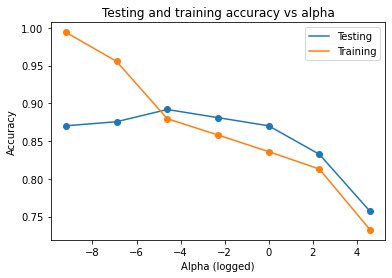

In [162]:
# Deliverable 3.1
alpha = np.array([0.0001,0.001,0.01,0.1,1.0,10.0,100.0])

acc_test = np.array([])
acc_train = np.array([])
for i in alpha:
    classifier_log = SGDClassifier(loss='log', max_iter=1000, tol=1.0e-12, random_state=123, eta0=100, average = False, alpha = i)
    classifier_log.fit(X_train, Y_train)
    
    test_accuracy = accuracy_score(Y_test, classifier_log.predict(X_test)) 
    train_accuracy = accuracy_score(Y_train, classifier_log.predict(X_train))
    
    
    acc_test = np.append(acc_test, test_accuracy)
    acc_train = np.append(acc_train, train_accuracy)
    

import matplotlib.pyplot as plt
    
plt.plot(np.log(alpha), acc_test, label = 'Testing')
plt.scatter(np.log(alpha), acc_test)
plt.plot(np.log(alpha), acc_train, label = 'Training')
plt.scatter(np.log(alpha), acc_train)
plt.title("Testing and training accuracy vs alpha")
plt.ylabel("Accuracy")

plt.xlabel("Alpha (logged)")
plt.legend()

In [173]:
# Deliverable 3.2
import statistics as stats

mean_android = np.array([])
for i in alpha:
    classifier_log = SGDClassifier(loss='log', max_iter=1000, tol=1.0e-12, random_state=123, eta0=100, average = False, alpha = i)
    classifier_log.fit(X_train, Y_train)
    
    mean_android = stats.mean(classifier_log.predict_proba(X_test)[:,0])
    print("alpha: " + str(i) + " --> " + str(mean_android))

alpha: 0.0001 --> 0.558736536555293
alpha: 0.001 --> 0.5198018531484025
alpha: 0.01 --> 0.5109166422748969
alpha: 0.1 --> 0.5228954516574309
alpha: 1.0 --> 0.5202971336274992
alpha: 10.0 --> 0.5040938155465652
alpha: 100.0 --> 0.50075937880869


In [163]:
# Deliverable 3.3
eta0_array = np.array([10.0, 100.0, 1000.0, 10000.0])
power_t_array = np.array([0.5, 1.0, 2.0])

def three_three(eta_0 = 100, power_t = 0.5):
    classifier_log2 = SGDClassifier(loss='log', max_iter=1000, tol=1.0e-12, random_state=123, eta0=eta_0, 
                                    power_t = power_t, average = False, learning_rate = 'invscaling')
    classifier_log2.fit(X_train, Y_train)
    return classifier_log2.n_iter_


for i in eta0_array:
    for j in power_t_array:
        print("eta0: " + str(i) + ", power_t: " + str(j) + " --> " + str(three_three(eta_0 = i, power_t = j)))

eta0: 10.0, power_t: 0.5 --> 96


/Users/nguyenkm13/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


eta0: 10.0, power_t: 1.0 --> 1000
eta0: 10.0, power_t: 2.0 --> 1000
eta0: 100.0, power_t: 0.5 --> 15
eta0: 100.0, power_t: 1.0 --> 1000
eta0: 100.0, power_t: 2.0 --> 1000
eta0: 1000.0, power_t: 0.5 --> 45
eta0: 1000.0, power_t: 1.0 --> 1000
eta0: 1000.0, power_t: 2.0 --> 1000
eta0: 10000.0, power_t: 0.5 --> 40
eta0: 10000.0, power_t: 1.0 --> 14
eta0: 10000.0, power_t: 2.0 --> 1000


Text(0.5, 1.0, 'Fig 3.5: Precision score vs tau')

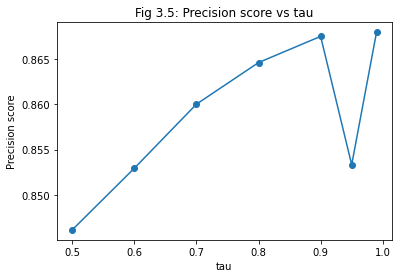

In [164]:
# use this function for deliverable 3.5
def threshold(probs, tau):
    return np.where(probs[:,0] > tau, 'Android', 'iPhone')

# your logistic regression code here

tau_array = np.array([0.5,0.6,0.7,0.8,0.9,0.95,0.99])

classifier = SGDClassifier(loss='log', max_iter=1000, tol=1.0e-12, random_state=123)
classifier.fit(X_train, Y_train)

probs_ = classifier.predict_proba(X_test)

import sklearn.metrics as metrics

precision_array = np.array([])
for i in tau_array:
        thresh = threshold(probs = probs_, tau = i)
        precision_array = np.append(precision_array, metrics.precision_score(Y_test, thresh, pos_label = 'Android'))
        
        
plt.plot(tau_array, precision_array)
plt.scatter(tau_array, precision_array)
plt.xlabel("tau")
plt.ylabel("Precision score")
plt.title("Fig 3.5: Precision score vs tau")

## Problem 4: Sparse learning [5604: 5 points; 4604: +3 EC points]

Add the `penalty` argument to `SGDClassifier` and set the value to `'l1'`, which tells the algorithm to use L1 regularization instead of the default L2. Recall from lecture that L1 regularization encourages weights to stay at exactly $0$, resulting in a more "sparse" model than L2. You should see this effect if you examine the values of `classifier.coef_`.

#### Deliverable 4.1: Write a function to calculate the number of features whose weights are nonzero when using L1 regularization. Calculate the number of nonzero feature weights when `alpha` is one of $[0.00001, 0.0001, 0.001, 0.01, 0.1]$. Create a plot where the x-axis is `alpha` and the y-axis is the number of nonzero weights, using a log scale for the x-axis.

See below.

Text(0.5, 1.0, 'Number of non-zero weights for L1 regulariztion')

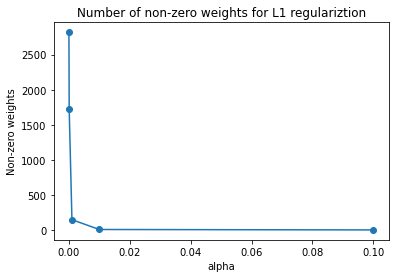

In [166]:
# your code here

alpha2 = np.array([0.00001,0.0001,0.001,0.01,0.1])

def problem4(alpha_ = 0.00001):
    classifier_sparse = SGDClassifier(loss='log', max_iter=1000, tol=1.0e-12, random_state=123, 
                                      penalty = 'l1', alpha = alpha_)
    classifier_sparse.fit(X_train, Y_train)
    non_zero = (classifier_sparse.coef_[0] != 0)

    return sum(non_zero)

non_zero_weights = np.array([])
for i in alpha2:
    non_zero_weights = np.append(non_zero_weights, problem4(i))

plt.plot(alpha2, non_zero_weights)
plt.scatter(alpha2, non_zero_weights)
plt.xlabel("alpha")
plt.ylabel("Non-zero weights")
plt.title("Number of non-zero weights for L1 regulariztion")
    